Fitting 5 folds for each of 420 candidates, totalling 2100 fits

Best Parameters: {'classifier__C': 10, 'classifier__penalty': 'l1', 'classifier__solver': 'liblinear', 'feature_selection__n_features_to_select': 6}

Selected Features: ['Absolute Magnitude', 'Orbit Uncertainity', 'Minimum Orbit Intersection', 'Jupiter Tisserand Invariant', 'Eccentricity', 'Avg_Diameter_KM']
Accuracy: 0.9466950959488273
F1 Score: 0.8351648351648352
Precision: 0.8333333333333334
Recall: 0.8370044052863436

Classification Report:
               precision    recall  f1-score   support

           0       0.97      0.97      0.97      1180
           1       0.83      0.84      0.84       227

    accuracy                           0.95      1407
   macro avg       0.90      0.90      0.90      1407
weighted avg       0.95      0.95      0.95      1407



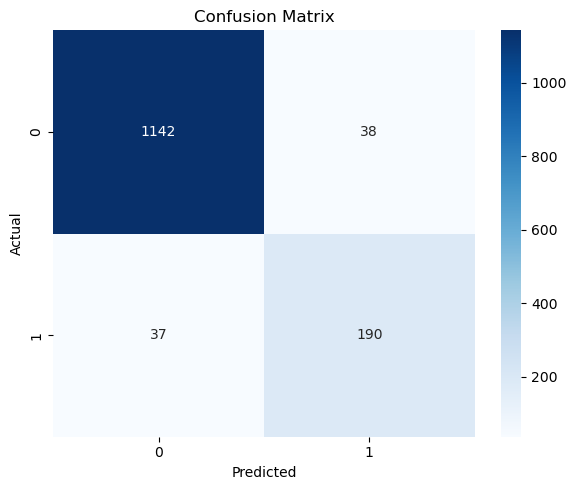

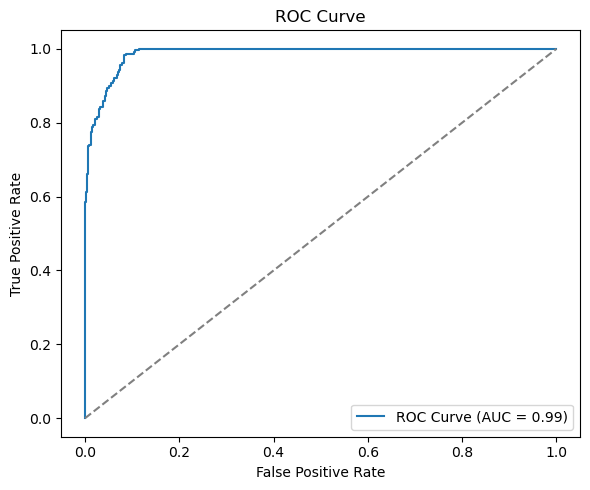

Model saved as best_logistic_model.pkl


In [ ]:
import pandas as pd
import joblib
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import RFE
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
import ml_helpers as hlp


def train_logistic_with_rfe(X_train, y_train, feature_names):
    """Train logistic regression model using RFE and GridSearchCV."""
    hlp.validate_training_data(X_train, y_train)
    pipe = Pipeline([
        ('feature_selection', RFE(estimator=LogisticRegression(max_iter=1000, solver='liblinear'))),
        ('classifier', LogisticRegression(max_iter=1000))
    ])

    param_grid = [
        {
            'feature_selection__n_features_to_select': list(range(1, X_train.shape[1] + 1)),
            'classifier__C': [0.1, 1, 10, 20, 50],
            'classifier__penalty': ['l1'],
            'classifier__solver': ['liblinear', 'saga']
        },
        {
            'feature_selection__n_features_to_select': list(range(1, X_train.shape[1] + 1)),
            'classifier__C': [0.1, 1, 10, 20, 50],
            'classifier__penalty': ['l2'],
            'classifier__solver': ['liblinear', 'saga', 'lbfgs', 'newton-cg']
        }
    ]

    grid = GridSearchCV(pipe, param_grid, cv=5, scoring='f1', n_jobs=-1, verbose=1)
    grid.fit(X_train, y_train)

    best_model = grid.best_estimator_
    selected_mask = best_model.named_steps['feature_selection'].support_
    selected_features = feature_names[selected_mask]

    # Save best features
    pd.DataFrame(selected_features).to_csv("best_features_logistic_re.csv", index=False, header=["Selected_Feature"])

    return best_model, selected_features, grid.best_params_


if __name__ == "__main__":
    filepath = "C:\\Users\\Jinane Rachid\\Desktop\\cleaned_nasa_data1.csv"

    # Load and prepare data
    X, y = hlp.load_data(filepath)
    X_train, X_test, y_train, y_test = hlp.split_data(X, y)

    feature_names = X_train.columns

    # Train model
    best_model, selected_features, best_params = train_logistic_with_rfe(X_train, y_train, feature_names)

    print("\nBest Parameters:", best_params)
    print("\nSelected Features:", selected_features.tolist())

    #Evaluate
    hlp.evaluate_model_basic(best_model, X_test, y_test)
    hlp.evaluate_model_with_proba(best_model, X_test, y_test)

    # Save model
    joblib.dump(best_model, "best_logistic_model.joblib")
    print("Model saved as best_logistic_model.joblib")